<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/unpack_HIC_pickles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from statistics import mean
import os
import gc
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from itertools import chain
from shapely.geometry import Point

!pip install diptest
import diptest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.7/195.7 kB 3.7 MB/s eta 0:00:00


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
set_lists =[np.array([73,  1, 60, 18, 58]),
            np.array([23, 76, 51, 63, 66]),
            np.array([31, 47, 30, 20,  5]),
            np.array([15, 77, 43, 53, 12]),
            np.array([ 3, 56, 29, 75, 13]),
            np.array([70, 42, 65, 52, 54]),
            np.array([46, 41, 50, 40, 82]),
            np.array([67, 24, 84, 61,  6]),
            np.array([26, 74, 17,  2, 44]),
            np.array([81, 71, 49, 45, 88]),
            np.array([22, 11, 86, 83, 14]),
            np.array([33, 27, 25, 59, 38]),
            np.array([68, 39, 78, 69, 87]),
            np.array([16, 19, 48, 21, 79]),
            np.array([57, 72, 80, 64, 28]),
            np.array([62, 85])]

In [4]:
result_list = [pickle.load(open(f'/content/drive/MyDrive/hawaii_soils/result_list_{set_list_id}.pkl', 'rb')) for set_list_id in range(len([set_lists]))]

In [5]:
with open('/content/drive/MyDrive/hawaii_soils/result_list_12.pkl', 'rb') as file:
    result_list = pickle.load(file)

In [6]:
# Assuming set_lists is a list or range with the correct number of files
result_list = [pickle.load(open(f'/content/drive/MyDrive/hawaii_soils/result_list_{set_list_id}.pkl', 'rb')) for set_list_id in range(len(set_lists))]


In [7]:
flattened_result_list = [item for sublist in result_list for item in sublist]

In [8]:
len([flattened_result_list[i]['xval_id'] for i in range(len(flattened_result_list))])

77

In [9]:
diptest_result_list = [ np.mean([(diptest.dipstat(dict_thing['imp_c_quantiles'])>.05) == (diptest.dipstat(thing)>.05) for thing in dict_thing['prediction_quantiles']]) for dict_thing in flattened_result_list]

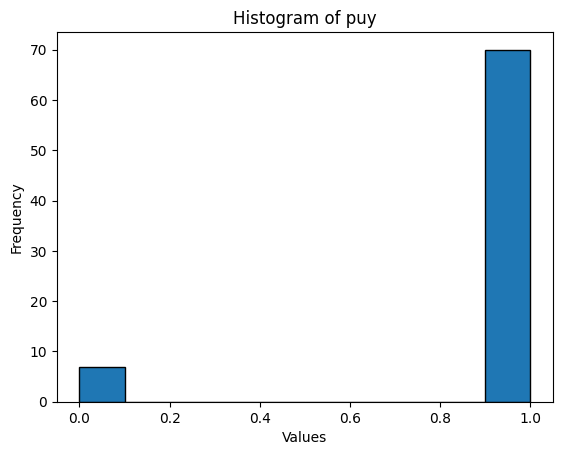

In [10]:
# Assuming 'puy' is a list of values
puy = diptest_result_list

# Create a histogram
plt.hist(puy, bins=10, edgecolor='black')  # You can adjust the number of bins
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of puy')
plt.show()

In [11]:
[i for i in flattened_result_list[0]]

['xval_id',
 'lat_lon',
 'xy_sample',
 'xy_driver',
 'imp_c_scaled',
 'imp_c_quantiles',
 'real_predicted_labels',
 'real_diptest',
 'scaled_predictions',
 'prediction_quantiles',
 'predicted_predicted_labels',
 'predicted_diptest']

4 things to validate:
classification
median predicts
k-s test
diptest
What is truth? Since we don't know, we are trying multiple methods to compare generated results to truth data. We don't know if the soil samples taken are good/true represenations of soc in that area. Variable numbers of soil samples that are used to represent a distribution. Lack spatially explicit data for all soil data (multiple cores associated with a single data point). Is there a spatial bias associated with any predictions? Spacial patterning of where soil samples were taken coming through? Are there sampling conditions that are biasing this in one way or another. (for another time) are my predictions for a given site better if they are closer to where the sampling points were? What is going wrong in the classification? Why is the generated data being poorly classified into distribution types? Next steps: refining model architecture, matching to the size and shape of the data, improving distribution classifier, spatial bias testing. How do things group?

In [12]:
flattened_result_list[0]['imp_c_scaled']

array([ 4.21507841,  6.54957664, 12.40945072, 18.52451287, 24.29932428])

there are 77 arrays of prediction quantiles: 0-76

In [13]:
len(flattened_result_list[76]['prediction_quantiles'])

201

In [25]:
from statistics import mode
from statistics import median
from collections import Counter

# representative_value = mode(flattened_result_list[0]['predicted_predicted_labels'])
# print(representative_value)

# print(flattened_result_list[0]['predicted_predicted_labels'])

# median(flattened_result_list[0]['predicted_predicted_labels'])

print(Counter(flattened_result_list[0]['real_predicted_labels']))
print(Counter(flattened_result_list[0]['predicted_predicted_labels']))

# most_common_n = Counter(flattened_result_list['predicted_predicted_labels']).most_common(n=3)  # Get top 3 most common values


Counter({'uniform': 1})
Counter({'uniform': 138, 'right tailed': 17, 'normal': 16, 'left tailed': 4})


In [29]:
from statistics import mode
from sklearn.metrics import confusion_matrix

correct_proportions = []
incorrect_proportions = []
modes = []

# Iterate over each dictionary in the list
for result in flattened_result_list:
    real_labels = result['real_predicted_labels']
    predicted_labels = result['predicted_predicted_labels']

    # Calculate the mode of predicted labels
    predicted_mode = mode(predicted_labels)
    modes.append(predicted_mode)

    # Create an array filled with the mode to match the length of real_labels
    predicted_mode_array = [predicted_mode] * len(real_labels)

    # Generate the confusion matrix
    cm = confusion_matrix(real_labels, predicted_mode_array)

    # Calculate proportions
    same_proportion = cm.trace() / cm.sum()
    different_proportion = 1 - same_proportion

    # Store the proportions
    correct_proportions.append(same_proportion)
    incorrect_proportions.append(different_proportion)


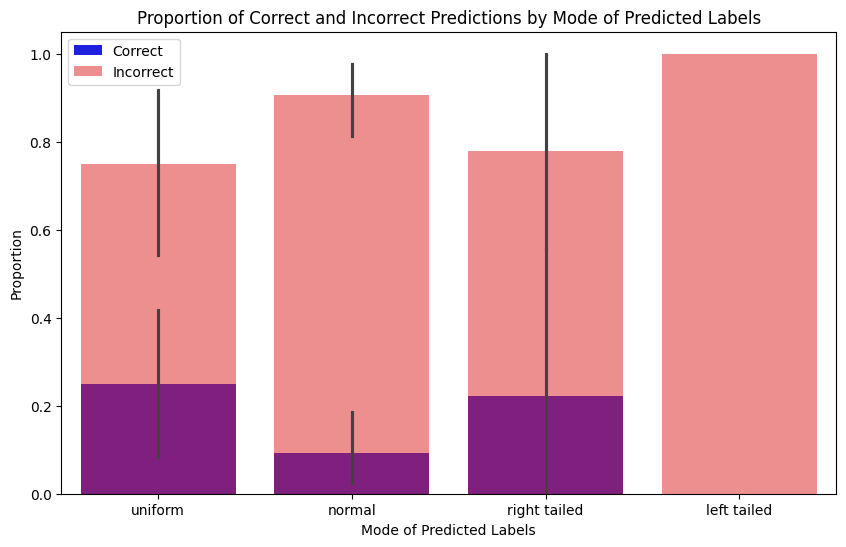

In [30]:

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Mode': modes,
    'Correct Proportion': correct_proportions,
    'Incorrect Proportion': incorrect_proportions
})

# Plot the proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='Mode', y='Correct Proportion', data=df, color='blue', label='Correct')
sns.barplot(x='Mode', y='Incorrect Proportion', data=df, color='red', label='Incorrect', alpha=0.5)

# Add labels and title
plt.xlabel('Mode of Predicted Labels')
plt.ylabel('Proportion')
plt.title('Proportion of Correct and Incorrect Predictions by Mode of Predicted Labels')
plt.legend()

# Display the plot
plt.show()


In [32]:
mean_correct = np.mean(correct_proportions)
mean_incorrect = np.mean(incorrect_proportions)

print(f"Mean Proportion of Correct Predictions: {mean_correct:.2f}")
print(f"Mean Proportion of Incorrect Predictions: {mean_incorrect:.2f}")

Mean Proportion of Correct Predictions: 0.16
Mean Proportion of Incorrect Predictions: 0.84


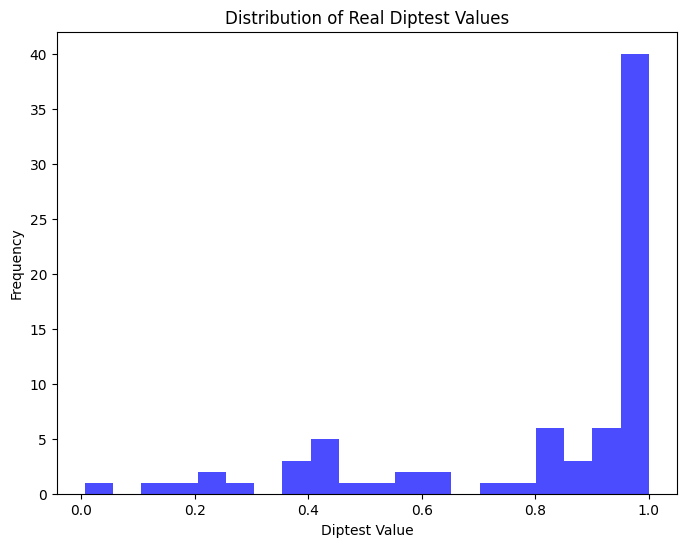

In [14]:
# for i, item in enumerate(flattened_result_list):
#     print(item['real_diptest'])

# Collect all real_diptest values
real_diptest_values = [item['real_diptest'] for item in flattened_result_list]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(real_diptest_values, bins=20, alpha=0.7, color='blue')
plt.title('Distribution of Real Diptest Values')
plt.xlabel('Diptest Value')
plt.ylabel('Frequency')
plt.show()


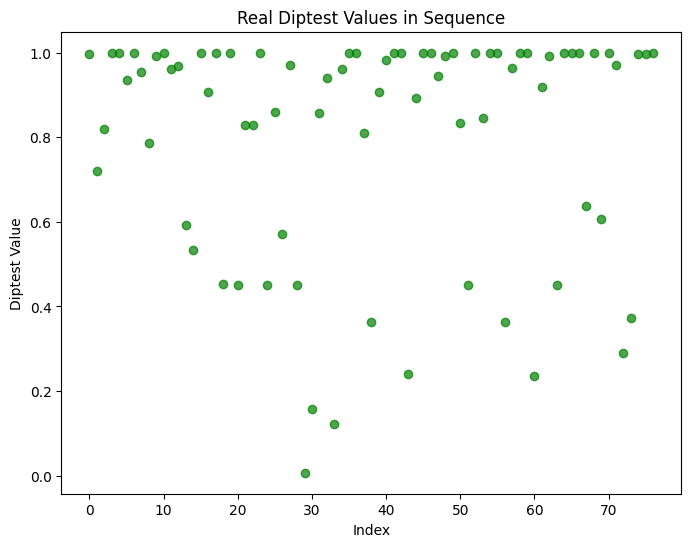

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(real_diptest_values)), real_diptest_values, alpha=0.7, color='green')
plt.title('Real Diptest Values in Sequence')
plt.xlabel('Index')
plt.ylabel('Diptest Value')
plt.show()

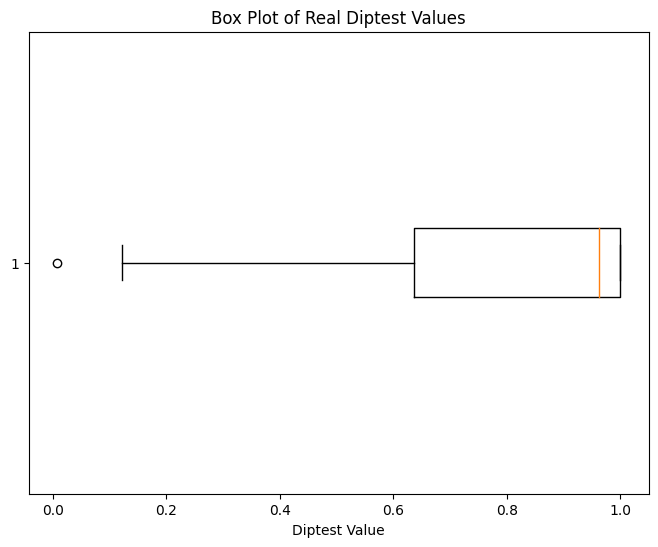

In [16]:
plt.figure(figsize=(8, 6))
plt.boxplot(real_diptest_values, vert=False)
plt.title('Box Plot of Real Diptest Values')
plt.xlabel('Diptest Value')
plt.show()

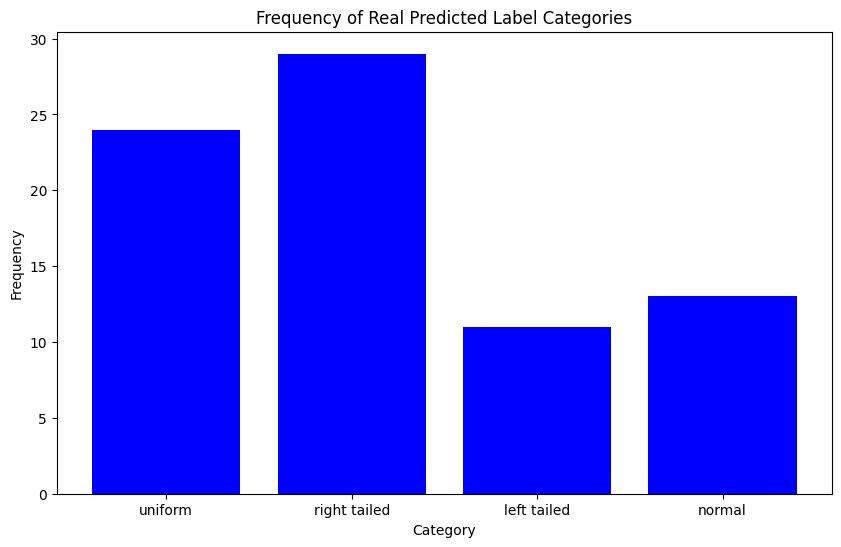

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

# Collect all values across all real_predicted_labels arrays
all_real_predicted_values = []

for item in flattened_result_list:
    real_predicted_labels_values = item['real_predicted_labels']
    if isinstance(real_predicted_labels_values, (np.ndarray, list)):
        all_real_predicted_values.extend(real_predicted_labels_values)

# Count the frequency of each category
category_counts = Counter(all_real_predicted_values)

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='blue')
plt.title('Frequency of Real Predicted Label Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()


In [18]:

# Create a DataFrame for better visualization

category_df = pd.DataFrame(category_counts, columns=unique_categories)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(category_df.T, annot=True, cmap='Blues', cbar=True)
plt.title('Heatmap of Category Frequencies Across Arrays')
plt.xlabel('Array Index')
plt.ylabel('Category')
plt.show()



NameError: name 'unique_categories' is not defined

In [33]:
# flattened_result_list[0]['xy_sample']

In [34]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry= [Point(point.x,point.y) for point in flattened_result_list[12]['xy_driver']] )
# gdf['predicted_predicted_labels'] = flattened_result_list[12]['predicted_predicted_labels']
gdf['real_predicted_labels'] = [flattened_result_list[12]['real_predicted_labels'][0] for i in range(len(gdf))]
gdf['predicted_predicted_labels'] = flattened_result_list[12]['predicted_predicted_labels']
gdf['scaled_predictions'] = [i[5] for i in flattened_result_list[12]['scaled_predictions']]

# Optionally, set a coordinate reference system (CRS)
gdf.set_crs(epsg=32604, inplace=True)  # Example CRS, replace with your appropriate CRS
gdf.to_file('example.gpkg')

In [35]:
# [(xval['real_predicted_labels'][0], max(set(xval['predicted_predicted_labels']), key=xval['predicted_predicted_labels'].count)) for xval in flattened_result_list ]

In [36]:
combined_list = list(chain([(xval['real_predicted_labels'][0], label) for xval in flattened_result_list for label in xval['predicted_predicted_labels']]))
print(combined_list)

[('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'uniform'), ('uniform', 'un

In [37]:
combined_list =  [
    (xval['real_predicted_labels'][0],
     max(set(xval['predicted_predicted_labels'].tolist()), key=xval['predicted_predicted_labels'].tolist().count))
    for xval in flattened_result_list ]

In [38]:
y_true= [o[0] for o in combined_list]
y_pred = [o[1] for o in combined_list]
# Define the labels
labels =list(set(y_true))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create a DataFrame for the confusion matrix with labels
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Display the confusion matrix with labels
print(cm_df)

              normal  left tailed  uniform  right tailed
normal             4            0        6             3
left tailed        6            0        3             2
uniform           16            0        6             2
right tailed      17            1        9             2


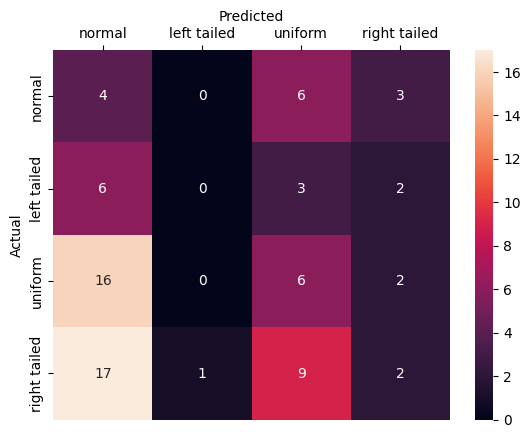

In [39]:

# Example data
y_true = [o[0] for o in combined_list]
y_pred = [o[1] for o in combined_list]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred,labels= list(set(y_true)))

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_df, annot=True, fmt='d', xticklabels=list(set(y_true)), yticklabels=list(set(y_true)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='left')
plt.gca().xaxis.set_ticks_position('top')  # Move x-axis ticks to the top
plt.gca().xaxis.set_label_position('top')  # Move x-axis label to the top
plt.show()

In [40]:
imput_results = [(item[5] , result['imp_c_quantiles'][5]) for result in flattened_result_list for item in result['prediction_quantiles']]

In [41]:
len(flattened_result_list[0]['xy_driver'])

175

In [42]:
unique_arrays = [list(x) for x in set(tuple(arr) for arr in flattened_result_list[0]['prediction_quantiles'])]

In [43]:
len(unique_arrays)

112

In [44]:
len(flattened_result_list[0]['prediction_quantiles'])

175

In [45]:
y_res_list = []
x_res_list = []
for quantile_n in range(10):
  # Calculate the mean of item[x] values directly for each result in flattened_result_list
  imput_results = [(mean(item[quantile_n] for item in result['prediction_quantiles']), result['imp_c_quantiles'][quantile_n]) for result in flattened_result_list]
  x_res = [i[0] for i in imput_results]
  y_res = [i[1] for i in imput_results]
  x_res_list.append(x_res)
  y_res_list.append(y_res)

y_res = [item for sublist in y_res_list for item in sublist]
x_res = [item for sublist in x_res_list for item in sublist]


In [46]:
# [result['imp_c_quantiles'][quantile_n] for result in flattened_result_list]

In [47]:
# max(x_res)[0]

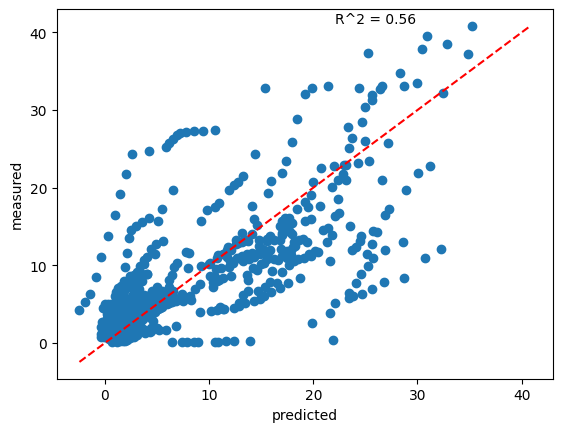

In [48]:
x_res = np.array(x_res).reshape(-1, 1)  # Reshape if data is a 1D array
y_res = np.array(y_res)

# Flatten x_res to match y_res dimensionality
x_res_flat = x_res.flatten()

# Perform linear regression
model = LinearRegression().fit(x_res, y_res)
r_squared = model.score(x_res, y_res)  # R-squared

# Create scatter plot
plt.scatter(x_res, y_res)
plt.xlabel('predicted')
plt.ylabel('measured')
plt.title('')

# Add a 1:1 line
max_val = max(max(x_res_flat), max(y_res))
min_val = min(min(x_res_flat), min(y_res))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # 1:1 line in red dashed

# Annotate the plot with the R-squared value
x_annotate = max(x_res_flat)
y_annotate = max(y_res)
plt.annotate(f'R^2 = {r_squared:.2f}', xy=(x_annotate, y_annotate), xycoords='data',
             xytext=(-40, 10), textcoords='offset points',
             ha='right', va='top')

plt.show()


In [49]:
# Convert any scalars to 1D arrays
x_res = [np.atleast_1d(arr) for arr in x_res]
y_res = [np.atleast_1d(arr) for arr in y_res]

# Flatten the list of arrays into a single array
x_res_flat = np.concatenate(x_res)  # Flatten list of arrays into a single array
y_res_flat = np.concatenate(y_res)  # Flatten list of arrays into a single array

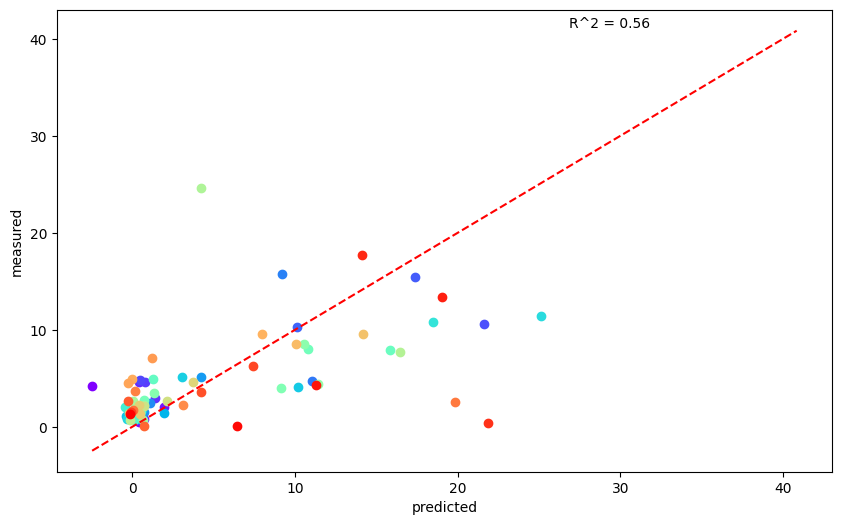

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm

# Example data setup
x_res = np.array(x_res).reshape(-1, 1)  # Reshape if data is a 1D array
y_res = np.array(y_res)

# Flatten x_res to match y_res dimensionality
x_res_flat = x_res.flatten()

# Number of arrays (77 in this case)
num_arrays = 77

# Generate colors using a colormap
colors = cm.rainbow(np.linspace(0, 1, num_arrays))

# Flatten the list of arrays into a single array
x_res_flat = np.concatenate(x_res)  # Flatten list of arrays into a single array
y_res_flat = np.concatenate(y_res)  # Flatten list of arrays into a single array

# Perform linear regression
model = LinearRegression().fit(x_res_flat.reshape(-1, 1), y_res_flat)
r_squared = model.score(x_res_flat.reshape(-1, 1), y_res_flat)  # R-squared

# Create scatter plot
plt.figure(figsize=(10, 6))

start = 0
for i in range(num_arrays):
    end = start + len(x_res[i])
    plt.scatter(x_res_flat[start:end], y_res_flat[start:end], color=colors[i], label=f'Array {i+1}')
    start = end

plt.xlabel('predicted')
plt.ylabel('measured')
plt.title('')

# Add a 1:1 line
max_val = max(max(x_res_flat), max(y_res_flat))
min_val = min(min(x_res_flat), min(y_res_flat))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # 1:1 line in red dashed

# Annotate the plot with the R-squared value
x_annotate = max(x_res_flat)
y_annotate = max(y_res_flat)
plt.annotate(f'R^2 = {r_squared:.2f}', xy=(x_annotate, y_annotate), xycoords='data',
             xytext=(-40, 10), textcoords='offset points',
             ha='right', va='top')

plt.show()



In [51]:
from scipy.stats import ks_2samp

# Your two arrays
quantiles_1 = [4.21507841,  5.25263318,  6.29018795,  8.502868, 11.10725648,
               13.76835342, 16.48615882, 19.16615858, 21.73274143, 24.29932428]

quantiles_2 = [-0.77422142, -0.45750624,  0.14001527,  0.71331972,  1.8816539,
                3.1818099 ,  3.54955769,  3.78713727,  4.94960022,  5.80645037]

# Perform the Kolmogorov-Smirnov test
passing_list = [np.mean([ks_2samp(quantiles_1, quantiles_2).pvalue > 0.05 for quantiles_1, quantiles_2 in zip([flattened_result_list[l]["imp_c_quantiles"] for i in range(len(flattened_result_list[l]["prediction_quantiles"]))], flattened_result_list[l]["prediction_quantiles"])]) for l in range(len(flattened_result_list))]


In [52]:
failing_list = [np.mean([ks_2samp(quantiles_1, quantiles_2).pvalue < 0.05 for quantiles_1, quantiles_2 in zip([flattened_result_list[l]["imp_c_quantiles"] for i in range(len(flattened_result_list[l]["prediction_quantiles"]))], flattened_result_list[l]["prediction_quantiles"])]) for l in range(len(flattened_result_list))]

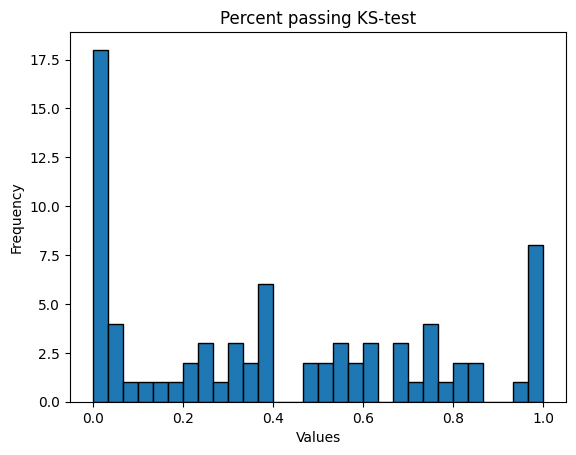

In [53]:
# Create a histogram
plt.hist(passing_list, bins=30, edgecolor='black')  # You can adjust the number of bins
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Percent passing KS-test')
plt.show()

In [54]:
np.mean([i >.5 for i in failing_list])

0.5844155844155844

In [55]:
np.mean([i >.5 for i in passing_list])

0.4025974025974026

In [56]:
passing_list[76]

0.31343283582089554